<a href="https://colab.research.google.com/github/elevien/phenotypic_variability_review/blob/main/cell_size_control_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

# Model definitions

In [2]:
def cell_size_trajectory(v0,alpha,sigma,tmax):
    t = [0]
    v = [v0]
    t_birth = [0]
    v_birth = [v0]
    dt = 0.005
    vdiv = 2*(1-alpha)*v0+2*alpha+np.random.normal(0,sigma)
    gr = 1 + np.random.normal(0,0.1)
    while t[-1]<tmax:
        v.append(v[-1]+v[-1]*gr*dt)
        if v[-1]>vdiv:
            v[-1]= v[-1]/2
            t_birth.append(t[-1])
            v_birth.append(v[-1])
            gr = 1 + np.random.normal(0,0.1)
            vdiv = 2*(1-alpha)*v[-1]+2*alpha+np.random.normal(0,sigma)
        t.append(t[-1]+dt)
    return t,v,t_birth,v_birth


def make_population_csr(Nmax,a,sigmav,sigmagr,seed,*,dt_sample=0.01,tmax=100):
    '''
    Simulate exponentially growing population using cell-size regulation model
    Also computes the fitness

    Input:
        Nmax        - the maximum number of cells to generate
        a           - cell-size regulation paramater
        sigmav      - size addative noise paramater
        sigmagr     - growth rate noise paramater
        seed        - generation time of ancestral cell
                        (relevant if there are correlations)

    Optional Input:
        tmax        - the maximum time to run
        dt_sample   - frequancy to save samples of the number of cells


    Output:
        N          - the number of cells at sample times
        T          - sample times
        L          - estimate of population growth rate from fitting
    '''
    def gen_time(vb,gr):
        xiv = np.random.normal(0.,sigmav)
        vf = 2*(1-a)*vb+2*a + xiv
        return np.log(vf/vb)/gr

    #cells =[Cell(gt,gt)]
    cells_gt = np.zeros(Nmax) # generation times
    cells_dt = np.zeros(Nmax) # division times
    cells_vb = np.zeros(Nmax)  # birth volumes
    cells_gr = np.zeros(Nmax)  # growth rates
    cells_vb[0] = 1.
    cells_gr[0] = 1.+np.random.normal(0.,sigmagr)
    cells_gt[0] = gen_time(cells_vb[0],cells_gr[0])
    cells_dt[0] = cells_gt[0]

    gen_times = np.zeros(2*Nmax)

    N = [1]
    V = [1.]
    n=1
    T = [0.]
    t_sample = 0.
    n = 1 # current number of cells
    n_tree = 1 # number of cells on entire tree
    t = 0.

    while n<Nmax and t<tmax:

        #cells.sort(key = lambda Cell : Cell.div_time) # can this be made more efficient?
        ind = np.argmin(cells_dt[0:n])
        mother_dt = cells_dt[ind]
        mother_gt = cells_gt[ind]
        mother_vb = cells_vb[ind]
        mother_gr = cells_gr[ind]
        mother_vf = mother_vb*np.exp(mother_gr*mother_gt)
        t_next = mother_dt
        gen_times[n_tree-1] = mother_gt

        cells_vb[ind] = mother_vf/2.
        cells_gr[ind] = 1.+np.random.normal(0.,sigmagr)
        cells_gt[ind] = gen_time(cells_vb[ind],cells_gr[ind])
        cells_dt[ind] = t_next + cells_gt[ind]


        cells_vb[n] = mother_vf/2.
        cells_gr[n] = 1.+np.random.normal(0.,sigmagr)
        cells_gt[n] = gen_time(cells_vb[ind],cells_gr[ind])
        cells_dt[n] = t_next + cells_gt[ind]

        t_sample += t_next-t
        t = t_next
        n = n+1
        n_tree = n_tree + 1

        # save samples
        t_last = T[-1]
        while t-t_last>dt_sample:
            t_last += dt_sample
            V.append(np.sum(cells_vb))
            T.append(t_last)
            N.append(n)
            t_sample = 0.

    # compute population growth rate
    def fit_func(x,a,b):
        return a*x+b
    fit_steps = len(T)//2 # fit to second half of time
    fits,errs = optimize.curve_fit(fit_func,T[fit_steps:-1],[np.log(n) for n in N[fit_steps:-1]])
    L = fits[0]
    if n>Nmax:
        print("Warning: n>Nmax")
    return np.array(N),np.array(V),np.array(T),L


# Simulations

First we will show some examples of population trajetories

In [4]:
N,V,T,L = make_population_csr(10000,0.00,0.2,0.01,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log


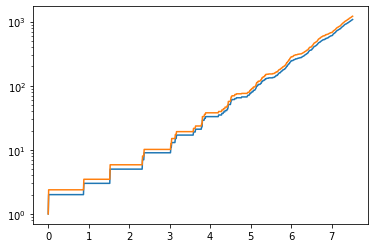

In [5]:
plt.semilogy(T,N)
plt.semilogy(T,V)

Here are some lineage trajectories showing the different between size with and without cell-size control

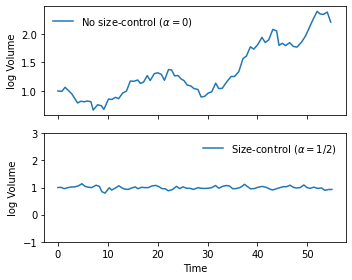

In [7]:
fig,axs = plt.subplots(nrows = 2,figsize=(5,4),sharex=True)

ax = axs[0]
t,v,tb,vb = cell_size_trajectory(1,0.,0.2,55)
ax.plot(tb,vb,label=r'No size-control ($\alpha=0$)')
ax.set_ylabel('log Volume')
ax.legend(frameon=False)

ax = axs[1]
t,v,tb,vb = cell_size_trajectory(1,0.5,0.1,55)
ax.plot(tb,vb,label=r'Size-control ($\alpha=1/2$)')

ax.set_ylabel('log Volume')
ax.set_xlabel('Time')
ax.set_ylim([-1,3])
ax.legend(frameon=False)
plt.tight_layout()